# Linear Regression

A notebook reproducing some of the examples from chapter 3 of Hastie, Tibshirani, Friedman, *The Elements of Statistical Learning*

In [1]:
from itertools import combinations
import pandas as pd
import numpy as np
import scipy.linalg as spl
import scipy.stats as sps
import scipy.optimize as spo
import matplotlib.pyplot as plt

In [2]:
from mlalgos.supervised_learning.linear_regression import (
    DummyRegression,
    LinearRegression,
    LassoRegression,
    PrincipalComponentsRegression,
    RidgeRegression,
    PartialLeastSquaresRegression
)
from mlalgos.utils.data_utils import StandardScaler, cross_validation_split
from mlalgos.utils.error_funcs import mean_squared_error
from mlalgos.utils.plotting import plot_cv_results

## Import some data

In [3]:
prostate_data = '~/datasets/prostate.txt'
df = pd.read_csv(prostate_data, sep='\t', usecols=[1,2,3,4,5,6,7,8,9,10])
df.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
0,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
1,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
2,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
3,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
4,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T


In [4]:
target = 'lpsa'
features = list(df)
features.remove('lpsa')
features.remove('train')
print(features)

['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45']


In [5]:
# use train flag to split
train = df.train == 'T'
X, y = df[features].values, df[target].values
X_train, y_train = X[train], y[train]
X_test, y_test = X[~train], y[~train]

In [6]:
# correlation matrix
corr = []
for feature1 in features:
    corr_list = []
    x1 = df[train][feature1].values
    mean1 = np.mean(x1)
    std1 = np.std(x1)
    for feature2 in features:
        x2 = df[train][feature2].values
        mean2 = np.mean(x2)
        std2 = np.std(x2)
        c = np.mean((x1-mean1)*(x2-mean2))/(std1*std2)
        corr_list.append(c)
    corr.append(corr_list)
print(corr)

[[1.0000000000000002, 0.30023198690216274, 0.28632426557510204, 0.06316772022296163, 0.592949130529482, 0.6920430753226345, 0.4264140724486782, 0.48316135710366304], [0.30023198690216274, 0.9999999999999999, 0.31672346842086035, 0.437041536580065, 0.1810544782843504, 0.15682859478541616, 0.023558207288831432, 0.0741663208573534], [0.28632426557510204, 0.31672346842086035, 0.9999999999999999, 0.28734644573788043, 0.12890226303142774, 0.172951397595152, 0.3659151225132289, 0.2758057291244312], [0.06316772022296163, 0.437041536580065, 0.28734644573788043, 0.9999999999999998, -0.13914679926810444, -0.08853455936907369, 0.032992152046930436, -0.030403819438876666], [0.592949130529482, 0.1810544782843504, 0.12890226303142774, -0.13914679926810444, 1.0, 0.6712402103032987, 0.3068753723785833, 0.48135774093302786], [0.6920430753226345, 0.15682859478541616, 0.172951397595152, -0.08853455936907369, 0.6712402103032987, 1.0000000000000002, 0.4764368357350071, 0.6625333515651151], [0.42641407244867

In [7]:
# correlation matrix using pandas (tab. 3.1)
df[train][features].corr()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
lcavol,1.000000,0.300232,0.286324,0.063168,0.592949,0.692043,0.426414,0.483161
lweight,0.300232,1.000000,0.316723,0.437042,0.181054,0.156829,0.023558,0.074166
age,0.286324,0.316723,1.000000,0.287346,0.128902,0.172951,0.365915,0.275806
lbph,0.063168,0.437042,0.287346,1.000000,-0.139147,-0.088535,0.032992,-0.030404
svi,0.592949,0.181054,0.128902,-0.139147,1.000000,0.671240,0.306875,0.481358
lcp,0.692043,0.156829,0.172951,-0.088535,0.671240,1.000000,0.476437,0.662533
gleason,0.426414,0.023558,0.365915,0.032992,0.306875,0.476437,1.000000,0.757056
pgg45,0.483161,0.074166,0.275806,-0.030404,0.481358,0.662533,0.757056,1.000000


In [8]:
# base error rate by simply predicting the mean
dummy_model = DummyRegression()
dummy_model.fit(X_train, y_train)
base_error_rate = mean_squared_error(y_test, dummy_model.predict(X_test))
print('Base error rate: ', base_error_rate)

Base error rate:  1.0567332280603818


In [9]:
# standardise for unit variance
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Compute linear regression and some statistics

In [10]:
# The difference in parameters compared to Tab 3.2 in ESL is due to standardising the data only on the training data,
# rather than the whole dataset, as done in the book. This propagates to later results
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
beta_names = ['Intercept'] + features
for i in range(len(beta_names)):
    print(beta_names[i], '\t', linear_model.beta_hat[i])

Intercept 	 2.4523450850746276
lcavol 	 0.7110405922561779
lweight 	 0.2904502919864316
age 	 -0.14148182348942576
lbph 	 0.210419510184796
svi 	 0.3073002529718587
lcp 	 -0.28684074913663926
gleason 	 -0.020756862036926726
pgg45 	 0.27526842547776587


In [11]:
# standard errors
X_tmp = np.insert(X_train, 0, 1, axis=1)
vary = np.sum((y_train - linear_model.predict(X_train))**2)/(len(y_train)-len(features)-1)
errs = np.sqrt(np.diagonal(spl.inv(X_tmp.T @ X_tmp)) * vary)
print(errs)

[0.08701959 0.13250132 0.10558798 0.10135462 0.1023518  0.12445059
 0.15364444 0.14151003 0.1583969 ]


In [12]:
# z score
z = []
for i in range(len(beta_names)):
    z.append(linear_model.beta_hat[i]/errs[i])
print(z)

[28.18152744197761, 5.3662904561505105, 2.750789389869384, -1.3959089818189574, 2.0558456259309086, 2.4692551777938414, -1.8669126353948038, -0.14668120644371685, 1.737839719569908]


In [13]:
result = zip(beta_names, linear_model.beta_hat, errs, z)
print('Term            Coeff    Std. Err      Z Score')
print('-----------------------------------------------')
for term, coefficient, std_err, z_score in result:
    print(f'{term:>10}{coefficient:>10.2f}{std_err:>9.2f}{z_score:>15.2f}')

Term            Coeff    Std. Err      Z Score
-----------------------------------------------
 Intercept      2.45     0.09          28.18
    lcavol      0.71     0.13           5.37
   lweight      0.29     0.11           2.75
       age     -0.14     0.10          -1.40
      lbph      0.21     0.10           2.06
       svi      0.31     0.12           2.47
       lcp     -0.29     0.15          -1.87
   gleason     -0.02     0.14          -0.15
     pgg45      0.28     0.16           1.74


In [14]:
# prediction error
pred_err = mean_squared_error(linear_model.predict(X_test), y_test)
print(f'{"Prediction error":20}{pred_err:5.2f}')
print(f'{"Base error":20}{base_error_rate:5.2f}')

Prediction error     0.52
Base error           1.06


In [15]:
# F score from dropping age, lcp, gleason, pgg45 (the features with lowest absolute z-score)
N = len(y_train)
RSS1 = mean_squared_error(linear_model.predict(X_train), y_train) * N
betas0 = linear_model.beta_hat.copy()
indxs = list(np.where(np.array(np.abs(z)) < 2)[0])
print('Dropping: ', np.array(beta_names)[indxs])
features0 = features.copy()
for i in indxs:
    features0.remove(beta_names[i])
X0_train = df[features0].values[train]
linear_model0 = LinearRegression()
linear_model0.fit(X0_train, y_train)
RSS0 = mean_squared_error(linear_model0.predict(X0_train), y_train) * N
p1 = 9
p0 = 5
F = ((RSS0-RSS1)/(p1-p0))/(RSS1/(N-p1))
Fdist = sps.f(p1-p0,N-p1-1)
p_val = Fdist.sf(F)
print(f'{"F = "}{F:.2f}')
print(f'{"p-value = "}{p_val:.2f}')

Dropping:  ['age' 'lcp' 'gleason' 'pgg45']
F = 1.67
p-value = 0.17


Thus we cannot reject the null hypothesis (of setting the four features with lowest absolute z-score to zero) as the p=0.05 level.

# Cross Validation and model selection

In [16]:
# An example to show the cross validation for linear regression model
cv_splits = cross_validation_split(X_train, y_train, 10)
errs = []
for split in cv_splits:
    linear_model = LinearRegression()
    linear_model.fit(split['train']['X'], split['train']['y'])
    errs.append(mean_squared_error(split['test']['y'], linear_model.predict(split['test']['X'])))

    
print(np.mean(errs))
print(np.std(errs))

0.48609164314373254
0.2951990638294327


# Subset Selection

In [17]:
def best_subset(
    model: LinearRegression,
    X_train: np.array,
    y_train: np.array,
    k: int = 1
) -> tuple[tuple[float], tuple[int]]:
    """
    Performs cross-validation for all possible models with subset k of the parameters.
    
    Args:
        model   (LinearRegression): a model which has methods fit(X, y) and predict(X, y)
        trainX          (np.array): input data
        trainY          (np.array): target data
        k                    (int): number of parameters in subset.

    Returns:
        tuple of (mean, std err) for the model with the best mean error, and tuple of indices of the k parameters
    """
    p = X_train.shape[1]
    if k > p:
        raise ValueError('subset length cannot exceed number of parameters')
    cv_means = []
    cv_stds = []

    subsets = list(combinations(range(p), k))
    
    for subset in subsets:
        X_tmp = X_train[:,subset]

        # Perform 10-fold cross-validation and record the mean and std
        cv_splits = cross_validation_split(X_tmp, y_train, 10)
        errs = []
        for split in cv_splits:
            model.fit(split['train']['X'], split['train']['y'])
            errs.append(mean_squared_error(split['test']['y'], model.predict(split['test']['X'])))
        
        cv_means.append(np.mean(errs))
        cv_stds.append(np.std(errs))

    best_idx = np.argmin(cv_means)
    return (cv_means[best_idx], cv_stds[best_idx]), subsets[best_idx]

In [18]:
model = LinearRegression()
best_subset(model, X_train, y_train, 8)

((0.631504094494906, 0.4312866728901534), (0, 1, 2, 3, 4, 5, 6, 7))

In [19]:
model = LinearRegression()
cv_means = []
cv_stds = []
for i in range(1,9):
    best = best_subset(model, X_train, y_train, i)
    cv_means.append(best[0][0])
    cv_stds.append(best[0][1])

dummy_model = DummyRegression()
cv_splits = cross_validation_split(X_train, y_train, 10)
dummy_errs = []
for split in cv_splits:
    dummy_model.fit(split['train']['X'], split['train']['y'])
    dummy_errs.append(mean_squared_error(split['test']['y'], dummy_model.predict(split['test']['X'])))
cv_means.insert(0, np.mean(dummy_errs))
cv_stds.insert(0, np.std(dummy_errs))

cv_means

[1.6208632525700986,
 0.7119157306151472,
 0.6163032382571143,
 0.5884308486101572,
 0.5512058519044658,
 0.5230346615819759,
 0.5312670649624354,
 0.5309302758541509,
 0.5844116829404408]

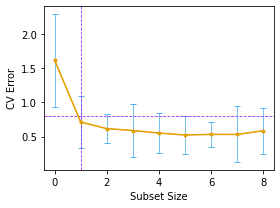

In [20]:
fig_subset = plot_cv_results(cv_means, cv_stds, list(range(0,9)), 'Subset Size')

# Ridge Regression

In [21]:
ridge_regressor0 = RidgeRegression(lam=2)
ridge_regressor0.fit(X_train, y_train)
mean_squared_error(ridge_regressor0.predict(X_test), y_test)
print(ridge_regressor0.beta_hat)

[ 2.45234509  0.66252159  0.28848496 -0.12759168  0.20638182  0.29640171
 -0.22642941 -0.00355767  0.23994133]


In [22]:
# Define number of degrees of freedom
def df(lam, d):
    return np.sum(d**2/(d**2+lam))

d = spl.svdvals(X_train)
df(2, d)

7.521731912539558

In [23]:
# Find the value of lambda that give a specific number of degrees of freedom
def df_root(lam, *val):
    return df(lam, d)-val[0]

lambdas = []
for i in range(1, 9):
    lambdas.append(spo.fsolve(df_root, 1, args=(i,))[0])
print(lambdas)
for l in lambdas:
    print(df(l, d))

[412.5108525273101, 156.6347870643663, 77.88075522290428, 42.24676320927057, 23.122008690980213, 11.80290089399027, 4.674120492002074, -9.254860797469404e-17]
1.0
2.000000000000008
3.0000000000000084
3.9999999999999996
5.0
6.000000000000001
7.0
8.0


In [24]:
cv_means_ridge = []
cv_stds_ridge = []
for l in lambdas:
    ridge_regressor = RidgeRegression(l)
    # Perform 10-fold cross-validation and record the mean and std
    cv_splits = cross_validation_split(X_train, y_train, 10)
    errs = []
    for split in cv_splits:
        ridge_regressor.fit(split['train']['X'], split['train']['y'])
        errs.append(mean_squared_error(split['test']['y'], ridge_regressor.predict(split['test']['X'])))
        
    cv_means_ridge.append(np.mean(errs))
    cv_stds_ridge.append(np.std(errs))
    

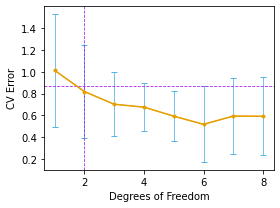

In [25]:
fig_ridge = plot_cv_results(cv_means_ridge, cv_stds_ridge, list(range(1,9)), 'Degrees of Freedom')

Text(0, 0.5, 'Coefficient')

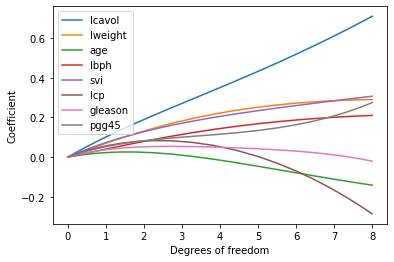

In [26]:
# Find how the coefficient values are affected by the number of degrees of freedom
lambdas = np.logspace(-5,10,100)
dfs = []
coeffs = []
for l in lambdas:
    dfs.append(df(l, d))
    ridge_model = RidgeRegression(l)
    ridge_model.fit(X_train, y_train)
    coeffs.append(ridge_model.beta_hat[1:])

fig, ax = plt.subplots()
for i in range(len(coeffs[0])):
    ax.plot(dfs,[coeff[i] for coeff in coeffs],label=beta_names[1:][i])
ax.legend()
ax.set_xlabel('Degrees of freedom')
ax.set_ylabel('Coefficient')

# Lasso

In [27]:
lasso = LassoRegression(15)
lasso.fit(X_train, y_train)
print(sum(np.abs(lasso.beta_hat[1:])))
mean_squared_error(lasso.predict(X_test), y_test)

0.8386020793756118


0.5012823679531441

In [42]:
cv_means_lasso = []
cv_stds_lasso = []
lambdas = [0.680, 0.380, 0.309, 0.100, 0.044, 0.027, 0.012, 0.001]
# lambdas = [0.680, 0.380, 0.209, 0.100, 0.044, 0.027, 0.012, 0.001]
# lambdas = [0.63, 0.6, 0.45, 0.35, 0.3, 0.2, 0.1]
t = []
#lambdas = [65, 55, 45, 38, 31, 27, 20, 15, 9]
for l in lambdas:
    lasso_regressor = LassoRegression(l)
    cv_splits = cross_validation_split(X_train, y_train, 10)
    errs = []
    for split in cv_splits:
        lasso_regressor.fit(split['train']['X'], split['train']['y'], num_epochs=1500, learning_rate=0.001)
        errs.append(mean_squared_error(split['test']['y'], lasso_regressor.predict(split['test']['X'])))
        
    cv_means_lasso.append(np.mean(errs))
    cv_stds_lasso.append(np.std(errs))
    t.append(sum(np.abs(lasso_regressor.beta_hat[1:])))
print(cv_means_lasso)
cv_means_lasso = [x for _, x in sorted(zip(t, cv_means_lasso))]
cv_stds_lasso = [x for _, x in sorted(zip(t, cv_stds_lasso))]
t = sorted(t)

[0.6250628981170794, 0.6061954242995033, 0.5702042228787194, 0.5912140284715974, 0.5996162019681779, 0.6177368730618411, 0.565867921957752, 0.6441847548150573]


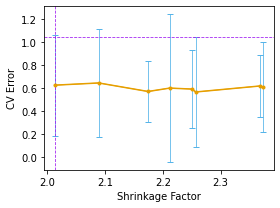

In [43]:
fig_lasso = plot_cv_results(cv_means_lasso, cv_stds_lasso, t, 'Shrinkage Factor')

#

# PCA Regression

In [32]:
pcr = PrincipalComponentsRegression(8)
pcr.fit(X_train, y_train)
mean_squared_error(pcr.predict(X_test), y_test)

0.5212740055076007

In [38]:
cv_means_pcr = []
cv_stds_pcr = []
ks = range(1,9)
for k in ks:
    pcr = PrincipalComponentsRegression(k)
    cv_splits = cross_validation_split(X_train, y_train, 10)
    errs = []
    for split in cv_splits:
        pcr.fit(split['train']['X'], split['train']['y'])
        errs.append(mean_squared_error(split['test']['y'], pcr.predict(split['test']['X'])))
        
    cv_means_pcr.append(np.mean(errs))
    cv_stds_pcr.append(np.std(errs))
        
print(cv_means_pcr)

[0.8834309253165612, 0.7961237751913177, 0.6823851999663753, 0.6396388986668853, 0.7320470187875903, 0.7337649619907903, 0.7223603383595897, 0.5494958625843822]


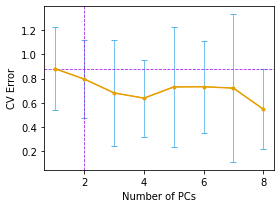

In [39]:
fig_pcr_skl = plot_cv_results(cv_means_pcr, cv_stds_pcr, list(range(1,9)), 'Number of PCs')